In [1]:
import numpy as np
import time
from tqdm import tqdm
import pickle
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt

import DAG_lib as dag

import itertools
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
with open("Transfusion Training data_20240311.pkl", 'rb') as pickle_file:
    data = pickle.load(pickle_file)
w,d,input_Xt,input_Y,T = dag.load_data(data)

ep_num=5000
lr=0.005

# best currently
# lr=0.005, decay_ep=3000, decay_ep=2000, decay_num=0.9 everything else default

# PGD - step 1: rough estimation
print("step 1 starting")
theta_whole, _ = dag.pgd(d, w, T, input_Xt, input_Y, ep_num=ep_num, lr=lr,decay_ep=3000)
A_fitted = theta_whole[:,1:]
mu_fitted =  theta_whole[:,0]
print("step 1 finished")
    
step2_dict = dag.cycle_find(A_fitted,w,d)
A_constraint = step2_dict["A_constraint"]
delta_lst = step2_dict["delta_lst"]

# Worker function adapted for use with concurrent.futures
def train_and_evaluate(params):
    lr, decay_num = params
    # Your function code here; make sure to return both params and tmperr_norm for identification
    theta_whole_linear, tmperr_norm = dag.pgd(d, w, T, input_Xt, input_Y, ep_num=5000, lr=lr, decay_ep=500, decay_num=decay_num, 
                                              my_penalty=dag.p_linear_circle, my_lambda=0.01, 
                                              A_constraint=A_constraint, delta_lst=delta_lst)
    step2_dict = dag.cycle_find(theta_whole_linear[:,1:],w,d)
    return params, tmperr_norm, step2_dict  # Return params and the final value of tmperr_norm

# Your parameter grid setup remains the same
lrs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
decay_nums = [0.9, 0.7, 0.5, 0.3, 0.1]
# decay_ep_values = [500, 1000, 1500, 2000, 2500, 3000]  # Example decay epochs

parameter_grid = list(itertools.product(lrs, decay_nums))

# Adapted execution with ProcessPoolExecutor and tqdm
results = []
with ProcessPoolExecutor(max_workers=30) as executor:
    # Create a future for each set of parameters
    futures = [executor.submit(train_and_evaluate, params) for params in parameter_grid]
    # Process the futures as they complete
    for future in tqdm(as_completed(futures), total=len(parameter_grid), desc="Grid Search Progress"):
        results.append(future.result())

# Analyzing results
results.sort(key=lambda x: x[0][0])  # Sort by tmperr_norm

# for (lr, decay_num), tmperr_norm, step2_dict in results:
#     print(lr, decay_num, step2_dict["all_closed_walk_num"],tmperr_norm[1000])

data loaded
step 1 starting
step 1 finished


Grid Search Progress: 100%|██████████| 30/30 [12:38<00:00, 25.28s/it]  


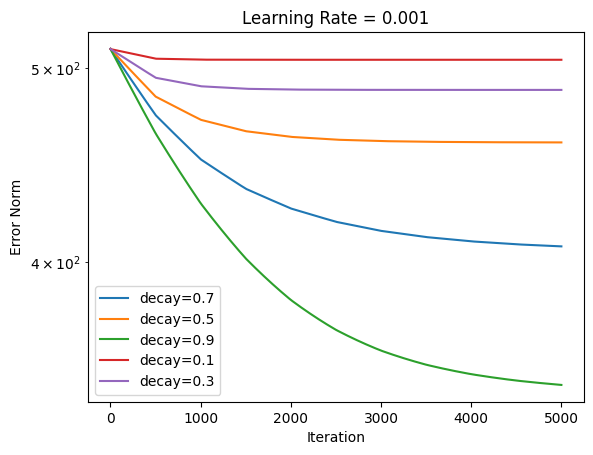

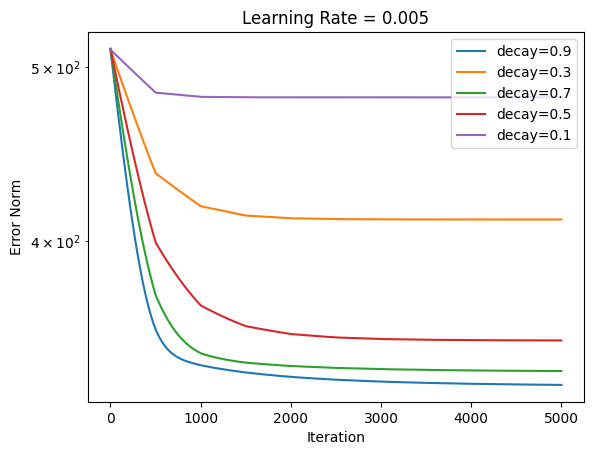

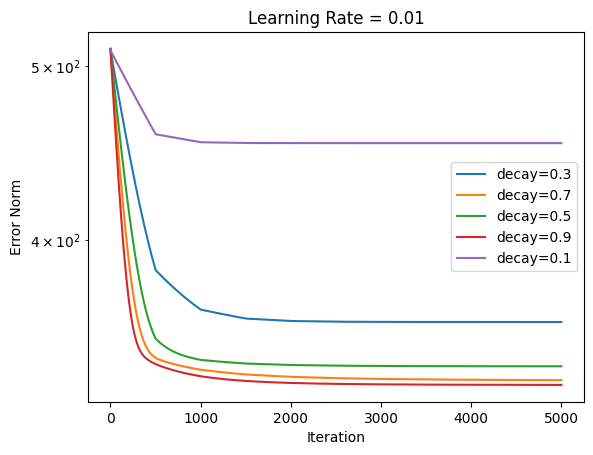

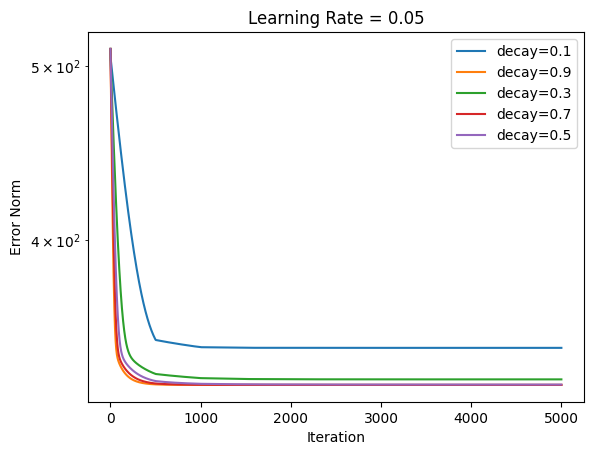

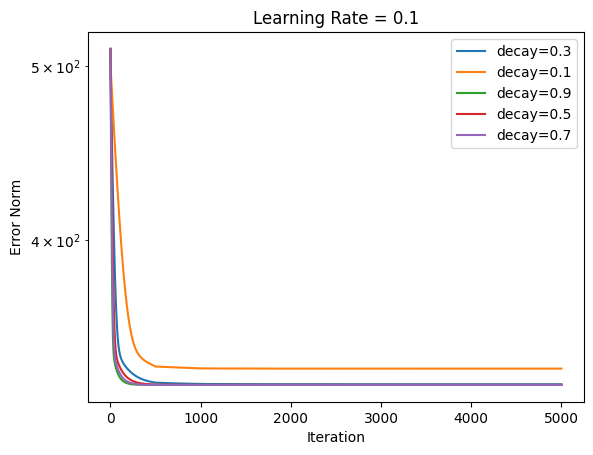

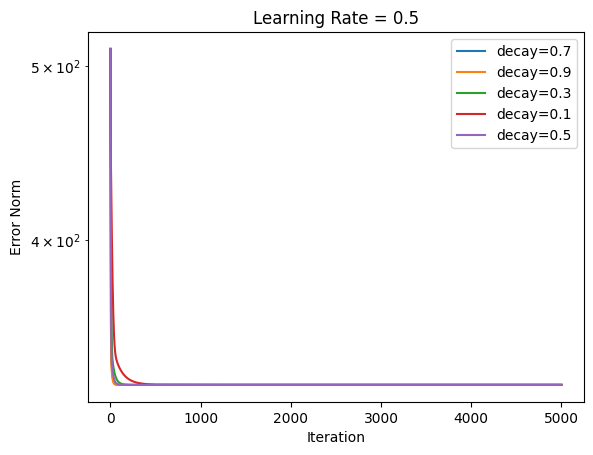

In [4]:
import matplotlib.pyplot as plt

# Assuming 'results' is your dataset
# Organize data by learning rate
data_by_lr = {}
for (lr, decay_ep), tmperr_norm, step2_dict in results:
    if lr not in data_by_lr:
        data_by_lr[lr] = []
    data_by_lr[lr].append((decay_ep, tmperr_norm, step2_dict))

# Plot data for each learning rate
for lr, data_list in data_by_lr.items():
    plt.figure()  # Start a new figure for each learning rate
    
    for decay_ep, tmperr_norm, step2_dict in data_list:
        plt.plot(tmperr_norm, label=f"decay={decay_ep}")  # You could also plot 'step2_dict' values if relevant
    
    plt.yscale("log")
    # plt.xscale("log")
    plt.title(f"Learning Rate = {lr}")
    plt.xlabel("Iteration")
    plt.ylabel("Error Norm")
    plt.legend()
    plt.show()


In [5]:
for (lr, decay_num), tmperr_norm, step2_dict in results:
    print(lr, decay_num, step2_dict["all_closed_walk_num"],tmperr_norm[1000])

0.001 0.7 {2: 124, 3: 264, 4: 1948} 450.2141584521893
0.001 0.5 {2: 124, 3: 264, 4: 1948} 471.22443508128174
0.001 0.9 {2: 122, 3: 258, 4: 1820} 427.92346665880103
0.001 0.1 {2: 124, 3: 264, 4: 1948} 505.06405714073674
0.001 0.3 {2: 124, 3: 264, 4: 1948} 489.7992111224474
0.005 0.9 {2: 66, 3: 87, 4: 284} 341.32207559902724
0.005 0.3 {2: 124, 3: 264, 4: 1948} 418.26275007788973
0.005 0.7 {2: 110, 3: 216, 4: 1444} 346.60370157269733
0.005 0.5 {2: 122, 3: 258, 4: 1820} 368.44614036639996
0.005 0.1 {2: 124, 3: 264, 4: 1948} 480.96901343172306
0.01 0.3 {2: 122, 3: 258, 4: 1820} 365.6306756178276
0.01 0.7 {2: 80, 3: 111, 4: 448} 338.36483395815424
0.01 0.5 {2: 114, 3: 225, 4: 1520} 342.6808371204337
0.01 0.9 {2: 30, 3: 9, 4: 32} 335.55637090673747
0.01 0.1 {2: 124, 3: 264, 4: 1948} 453.48731941851577
0.05 0.1 {2: 122, 3: 258, 4: 1820} 348.27694214782935
0.05 0.9 {2: 16, 3: 0, 4: 0} 331.7675711872055
0.05 0.3 {2: 80, 3: 120, 4: 480} 334.67754061722593
0.05 0.7 {2: 16, 3: 0, 4: 0} 331.82017686

In [7]:
step2_dict.keys()

dict_keys(['delta_lst', 'A_constraint', 'all_closed_walk_num', 'all_closed_walk_weights', 'all_closed_walk_edge', 'all_closed_walk_edge_weight'])

In [ ]:
with open("Transfusion Training data_20240311.pkl", 'rb') as pickle_file:
    data = pickle.load(pickle_file)
w,d,input_Xt,input_Y,T = dag.load_data(data)

ep_num=5000
lr=0.005
decay_ep=3000

# PGD - step 1: rough estimation
print("step 1 starting")
theta_whole, _ = dag.pgd(d, w, T, input_Xt, input_Y, ep_num=ep_num, lr=lr, decay_ep=decay_ep, )
A_fitted = theta_whole[:,1:]
mu_fitted =  theta_whole[:,0]
print("step 1 finished")
    
step2_dict = dag.cycle_find(A_fitted,w,d)
A_constraint = step2_dict["A_constraint"]
delta_lst = step2_dict["delta_lst"]



theta_whole_linear, tmperr_norm = dag.pgd(d, w, T, input_Xt, input_Y, ep_num=ep_num, lr=0.01, decay_ep=500, 
                         my_penalty=dag.p_linear_circle, my_lambda=0.01, 
                         A_constraint=A_constraint, delta_lst=delta_lst)

plt.plot(tmperr_norm)